<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# **PyTorch Custom Datasets**

The steps we took are similar across many different problems in machine learning: **Get dataset**, **turn the dataset into numbers**, **build a model** (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, we'll often want to use our own **custom dataset**.

## **What is a custom dataset?**

A **custom dataset** is a collection of data relating to a specific problem.
For example,
* for building a food image classification app like [Nutrify](https://nutrify.app), the custom dataset might be **images of food**.

* to build a model to classify whether or not a text-based review on a website was positive or negative, thre custom dataset might be examples of existing **customer reviews and their ratings**.

* to build a sound classification app, the custom dataset might be **sound samples alongside their sample labels**.

* to build a recommendation system for customers purchasing products on a website, the custom dataset might be **examples of products** other people have bought.

PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

Sometimes the existing functions functions in PyTorch may not be enough.
In that case, we can always subclass `torch.utils.data.Dataset` and customize it to the liking.

## **What we're going to cover**

We're going to be applying the PyTorch Workflow to a **computer vision problem**.
But instead of using an in-built PyTorch dataset, we're going to be using our **own dataset of pizza, steak and sushi images**.

The goal will be to **load these images** and then **build a model** to train and **predict** on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Get data** | Own **custom dataset** of pizza, steak and sushi images. |
| **2. Data preparation** | Take some steps to figure out what data we have. |
| **3. Transforming data** |To *transform* images and make them ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | One of the data loading functions for standard classification format images. |
| **5. Loading image data with a custom `Dataset`** | Build own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Common technique for expanding the diversity of the training data. |
| **7. Model 0: TinyVGG without data augmentation** | Training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | How the model is training/improving over time; also **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | How about we try one *with* data augmentation? |
| **10. Compare model results** | Different models' loss curves and options for improving performance. |
| **11. Making a prediction on a custom image** | Predict on an image *outside* of the existing dataset. |

**Setting Up Device-Agnostic Code**

In [37]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1+cu118'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **1. Get data and Preparation**

Machine learning is an **iterative** process, **start small, get something working and increase when necessary**.

The data we're going to be using is a subset of the original [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: **pizza**, **steak** and **sushi**.
And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data I downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook Daniel used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

**Note:**

> The dataset we're about to use has been **pre-formatted** for what we'd like to use it for. However, we'll often have to **format our own datasets** for whatever problem we're working on. This is a regular practice in the machine learning world.


* Python's `os` for **dealing with directories** (the data is stored in directories).
* Python's `pathlib` for **dealing with filepaths** (each of the images has a **unique file path**).

In [39]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")                                             # Setup path to data folder
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():                                               # If folder doesn't exist, download it and prepare it...
    print(f"{image_path} directory already exists, download skipped.")
else:
    image_path.mkdir(parents = True, exist_ok = True)
    print(f"{image_path} directory created.")
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:      # Download pizza, steak, sushi data
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)
        print("pizza_steak_sushi downloaded.")
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: # Unzip pizza, steak, sushi data
        zip_ref.extractall(image_path)
        print("pizza_steak_sushi unzipped.")

data/pizza_steak_sushi directory already exists, download skipped.


Remember, these images are subsets as toy example of the original [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).


Before starting building any kind of model, it's important to know **what data** we're working with. The first step is to **load the images from the folder structure** which can be done using libraries like **OpenCV** or **PIL** (Python Imaging Library). Alongside loading the images, we need to **associate labels or class identifiers with each image**. This can be achieved by **parsing the folder structure**, where **each subfolder represents a different class**, or by **reading label information** from an accompanying file.

## **1.1. Image Data Directory Structure**

**Image classification format** is a **directory structure** that contains **different classes of images** in **seperate directories** titled with a particular **class name** (i.e., folder name - root directory).

We can see an example of the storage format below in a **standard image classification format**. For example, all images of `pizza` are contained in the `pizza/` directory, same is true for `steak` and `sushi`. However, the **images numbers are arbitrary**.

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal is, then, to **take this data storage structure and turn it into a dataset usable with PyTorch**.

## **1.2. Inspecting Images Directory**

We can inspect what's in the data **directory** by writing a small helper function to walk through **each of the subdirectories and count the files** present.
To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

In [40]:
import os
def look_directory(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"In '{dirpath}', there are {len(dirnames)} directories and {len(filenames)} images.")

In [41]:
look_directory(image_path)

In 'data/pizza_steak_sushi', there are 2 directories and 0 images.
In 'data/pizza_steak_sushi/train', there are 3 directories and 0 images.
In 'data/pizza_steak_sushi/train/sushi', there are 0 directories and 72 images.
In 'data/pizza_steak_sushi/train/steak', there are 0 directories and 75 images.
In 'data/pizza_steak_sushi/train/pizza', there are 0 directories and 78 images.
In 'data/pizza_steak_sushi/test', there are 3 directories and 0 images.
In 'data/pizza_steak_sushi/test/sushi', there are 0 directories and 31 images.
In 'data/pizza_steak_sushi/test/steak', there are 0 directories and 19 images.
In 'data/pizza_steak_sushi/test/pizza', there are 0 directories and 25 images.


It looks like we've got about 75 (=(72+75+78)/3) images per training class and 25 (=(31+19+25)/3) images per testing class.

Since, the data is already splited into train and test,
let's setup the training and testing paths.

In [42]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## **1.3 Visualization Using Python Image Library (PIL)**

We've seen how the **directory structure is formatted**.
1. Get **all of the image paths** using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a **random image path** using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the **image class name** using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. **Open the random image** using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).

1. Get all image paths (`*` means "any combination")

In [43]:
import random
from PIL import Image
image_paths = list(image_path.glob("*/*/*.jpg")) # `(Train, Test)->(Pizza, Steak, Sushi)->Images`.
len(image_paths)

300

2. Get a random image path

In [44]:
# random.seed(42)
random_image_path = random.choice(image_paths)
print(random_image_path)
random_image_path

data/pizza_steak_sushi/train/pizza/3269634.jpg


PosixPath('data/pizza_steak_sushi/train/pizza/3269634.jpg')

3. Get image class from the path name (the image class is the name of the directory where the image is stored).

In [45]:
image_class = random_image_path.parent.stem
image_class

'pizza'

4. Open the random image using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (`PIL` stands for Python Image Library).

Random image path: data/pizza_steak_sushi/train/pizza/3269634.jpg
Image class: pizza
Image height: 512
Image width: 512


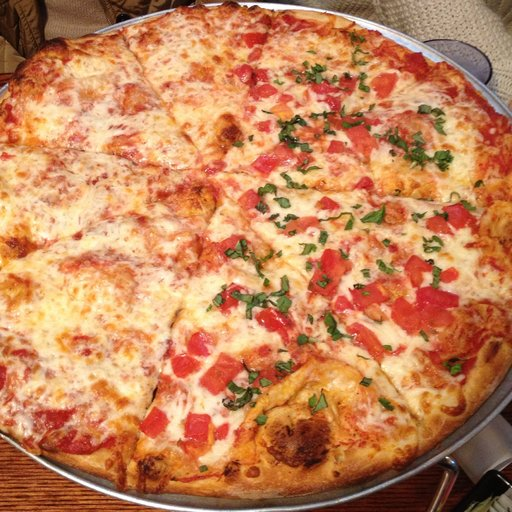

In [46]:
image = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}")
print(f"Image width: {image.width}")
image

## **1.4. Image Encoding**

Images are inherently **visual** data consisting of **pixels with varying intensity values** for different colors or grayscale levels.
In order to extract meaningful patterns and features from the image data, the **visual information** contained in an image should be transformed into a **structured format** that can be processed by computational algorithms. \\

The process of **converting images into numerical representation** is commonly referred to as "**image encoding**" or "**image digitization**". Image encoding involves representing **each pixel or region of an image as numerical values**. This numerical representation allows algorithms to perform mathematical operations, apply various transformations, and extract meaningful features from the images.

One form of image encoding is representing each pixel as a **grayscale intensity value** (ranging from 0 to 255) or as separate **Red, Green, and Blue (RGB) channel values** (ranging from 0 to 255 for each channel) for color images. This representation treats each pixel independently and is widely used for basic image processing tasks.

#### **Image to Numpy Array**

To convert images to a numerical representation, one commonly used approach is to represent them as **NumPy arrays**.

In [47]:
import numpy as np

image = Image.open(random_image_path)
image_array = np.asarray(image)
image_array.shape # -> `[height, width, color_channels]`

(512, 512, 3)

Each pixel of the image is represend numerically from 0 to 255 whose data type is `torch.uint8`.

In [48]:
image_array.dtype

dtype('uint8')

We can plot of the numpy array form of the image using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html).

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape}")
plt.axis(False);

#### **Image Array to Tensor**

In [50]:
image_tensor = torch.from_numpy(image_array.copy())
image_tensor.shape # -> `[height, width, color_channels]`

torch.Size([512, 512, 3])

In [51]:
image_tensor.dtype

torch.uint8

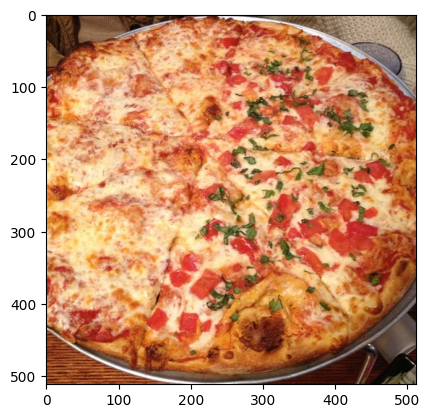

In [52]:
plt.imshow(image_tensor);

Note `[height, width, color_channels]` is the default for `PIL` and `matplotlib`, **same format is reserved when converting to tensor**.

## **1.5. Image Transformations**

The loaded images often need to be transformed or preprocessed including resizing the images to a consistent size, normalizing pixel values, converting color spaces, or applying data augmentation techniques such as random cropping or flipping.

A variety of **image transformations** that can be applied to tensors or PIL images can be done using the `torchvision.transforms` module.

Let's now got a way to  using `torchvision.transforms`.


### **Common Transformation**

1. Resize images to a specific size using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize). Generally, the **larger the shape** of the image, the **more information** a model can recover. For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`). However, the tradeoff is that **more pixels requires more computations**.
2. Flip images randomly on horizontally using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip). This could be considered a form of data augmentation because it will artificially change the image data.
3. Turn images from a **PIL** format or **numpy array** to a PyTorch **tensor** using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor). This also normlizes **all pixel values from 0 to 255** (datatype `torch.uint8`) to **between 0.0 and 1.0** (datatype `torch.float32`).

These transformations can be applied **individually** or they can be **combined** using the [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) class, which allows us to chain multiple transformations together in a specific order**.

In [53]:
from torchvision import transforms
image_transform = transforms.Compose([         # Can also use nn.Sequential()
    transforms.Resize(size=(64, 64)),          # Resize the images to 64x64
    transforms.RandomHorizontalFlip(p = 0.5),  # Flip the images randomly on the horizontal
    transforms.ToTensor()                      # Turn the image into a torch.Tensor
    ])

In [54]:
transformed_image_tensor = image_transform(image)
transformed_image_tensor

tensor([[[0.3529, 0.3647, 0.3765,  ..., 0.3725, 0.3059, 0.1922],
         [0.3451, 0.3882, 0.4941,  ..., 0.3059, 0.2196, 0.1725],
         [0.3725, 0.4863, 0.6118,  ..., 0.2353, 0.1922, 0.2078],
         ...,
         [0.2980, 0.1098, 0.0471,  ..., 0.5490, 0.5725, 0.5843],
         [0.4784, 0.3882, 0.2314,  ..., 0.5569, 0.5686, 0.5608],
         [0.4431, 0.4471, 0.3765,  ..., 0.5961, 0.5373, 0.5333]],

        [[0.2745, 0.2902, 0.3098,  ..., 0.2196, 0.1765, 0.1059],
         [0.2706, 0.3137, 0.4235,  ..., 0.1765, 0.1176, 0.0902],
         [0.2941, 0.4118, 0.5333,  ..., 0.1333, 0.1020, 0.1059],
         ...,
         [0.2588, 0.0980, 0.0431,  ..., 0.2588, 0.2745, 0.2824],
         [0.4314, 0.3529, 0.2039,  ..., 0.2667, 0.2784, 0.2706],
         [0.4000, 0.4157, 0.3412,  ..., 0.2980, 0.2471, 0.2431]],

        [[0.1843, 0.1961, 0.2157,  ..., 0.1020, 0.0902, 0.0588],
         [0.1765, 0.2196, 0.3373,  ..., 0.0863, 0.0588, 0.0431],
         [0.1922, 0.3255, 0.4431,  ..., 0.0667, 0.0549, 0.

In [55]:
image_array.shape, transformed_image_tensor.shape

((512, 512, 3), torch.Size([3, 64, 64]))

**Mine**:

> Note that while `[height, width, color_channels]` is the default for `PIL` and `matplotlib`, the default format in PyTorch is `[color_channels, height, width]`.

> Hence, to be compatible with `matplotlib`, the order of its dimensions should be rearranged to `[height, width, color_channels]`. To do so, `.permute()` can be used.

  `[height, width, color_channels]<-[color_channels, height, width].permute(1, 2, 0)`

In [56]:
image_array.dtype, transformed_image_tensor.dtype

(dtype('uint8'), torch.float32)

Now we've got a composition of transforms, let us compare the original and transformed images.

In [57]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(image_array)
axis[0].set_title(f"Original \nSize: {image_array.shape}")
axis[0].axis("off")
axis[1].imshow(transformed_image_tensor.permute(1, 2, 0)); # ([H, W, C]<- [C, H, W]) -> permute() do this
axis[1].set_title(f"Transformed \nSize: {transformed_image_tensor.shape}")
axis[1].axis("off")
figure.suptitle(f"Class: {random_image_path.parent.stem}", fontsize=12)
plt.imshow(image_array);

Let's write a function to try out on various images.

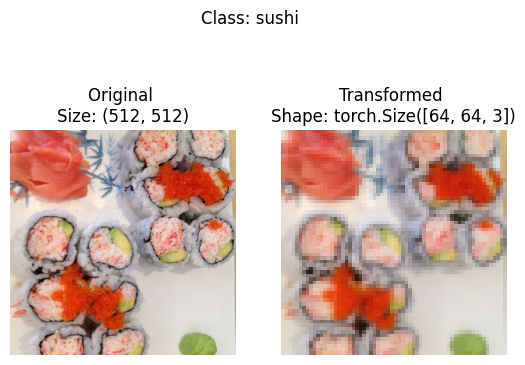

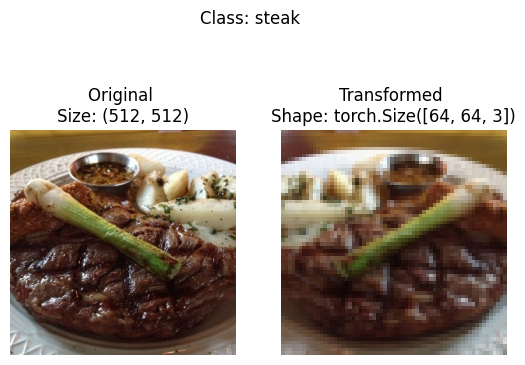

In [58]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_img_tensor = transform(f).permute(1, 2, 0) # ([H, W, C]<- [C, H, W])
            ax[1].imshow(transformed_img_tensor)
            ax[1].set_title(f"Transformed \nShape: {transformed_img_tensor.shape}")
            ax[1].axis(False)
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)

plot_transformed_images(image_paths, transform = image_transform, n = 3)

### **More On Data Augmentation**

The purpose of tranforms ([`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html)) is to alter the images in some way.
That may be turning the images into a tensor (as we've seen before).
Or cropping it or randomly erasing a portion or randomly rotating them.
Doing this kinds of transforms is often referred to as **data augmentation** (looking the same data from different perspective(s): rotate, shift, zoom).

**Data augmentation** is the process of altering the data  in such a way that we **artificially increase the diversity** of the training set.
Training a model on this artificially altered dataset hopefully results in a model that is capable of better **generalization** (the patterns it learns are more robust to future unseen examples).
Many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's [Illustration of Transforms example](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms).

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms. `TrivialAugment` was one of the ingredients used in a recent [state of the art](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements) training upgrade to various PyTorch vision models.

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.
It defines **how much of a range an intensity value** will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity).
We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

How about we test it out on some of our own images?


In [59]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                          #  224x224 = common size in image classification
    transforms.TrivialAugmentWide(num_magnitude_bins=31),   # how intense
    transforms.ToTensor()                                   # use ToTensor() last to get everything between 0 & 1
    ])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()                                   # No need to perform augmentation on the test data
    ])

**Note:** The idea of data augmentation is to to **artificially increase the diversity of the training set** to better predict on the testing set.
* But, we usually **don't perform data augmentation on the test set**.
* However, we do need to make sure the **test set images are transformed to tensors**.
* We **size the test images to the same size as the training images too**.
* However, **inference can be done on different size images** if necessary (though this may alter performance).

Let's test the data augmentation out! We've got a training transform (with data augmentation) and test transform (without data augmentation).

In [60]:
image_path

PosixPath('data/pizza_steak_sushi')

In [61]:
image_paths = list(image_path.glob("*/*/*.jpg")) # Get all image paths
image_paths[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2674024.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/170385.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2641778.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1280119.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2797464.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2590819.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/794647.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/148799.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1615453.jpg')]

 Plot random images to see the impact of `TrivialAugment`.

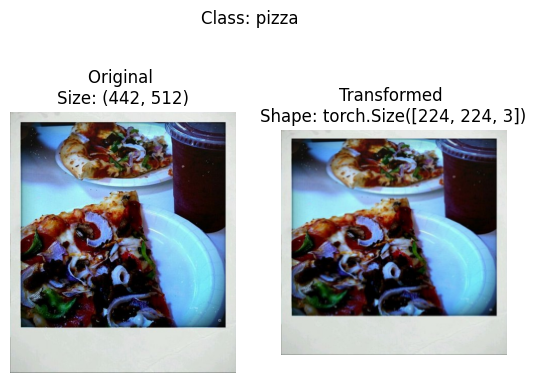

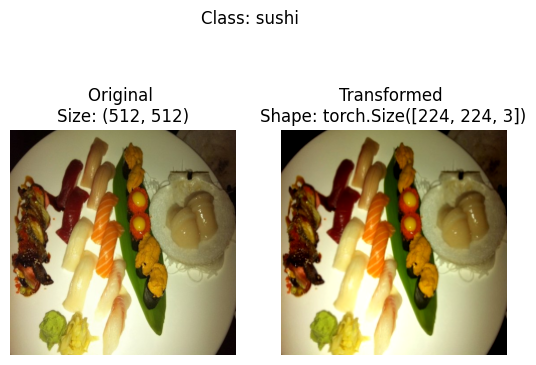

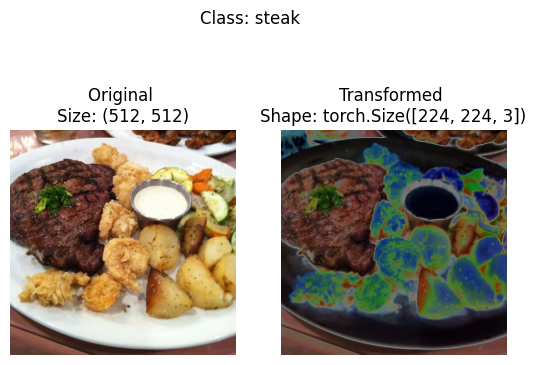

In [62]:
plot_transformed_images(
    image_paths = image_paths,
    transform = train_transforms,
    n = 3,
    seed = None
)

Try running the cell above a few times and see how the original image changes as it goes through the transform.

**Mine**: The impact of the augmentation is **not the same for each image**.

## **1.6. Creating Torch Dataset**

The base class for all Torch datsets is `torch.utils.data.Dataset`, specifically designed for **handling data in the PyTorch framework**.

`torch.utils.data.Dataset` is a fundamental component in PyTorch's data loading and preprocessing pipeline. It is part of the PyTorch `torch.utils.data` module and provides an abstract interface for creating custom datasets. When creating a custom dataset, we need to implement two essential methods: `__len__()` and `__getitem__()`.

  * **`__len__()` Method**: This method returns the **number of samples** in our dataset. It allows us to use the Python `len()` function on an instance of our dataset to get the dataset's size.

  * **`__getitem__()` Method**: This method is responsible for loading and preprocessing a **single data sample** from our dataset. Given an **index**, it should return the corresponding **data sample**. We can perform any necessary data transformations (e.g., image resizing, data augmentation) within this method.

**Torch Dataset** is typically used in combination with **Torch DataLoader** (`torch.utils.data.DataLoader`). The `DataLoader` converts the the dataset into batch-based **iterable** format and provides other features.

There are several different kinds of pre-built Datasets and DataLoaders for PyTorch, depending on the problem we are working on; **vision**: [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html), **audio**: [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html), **text**: [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html), **recommendation system**: [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html).


Once the **images and labels are loaded and transformed,** they need to be organized into a format suitable for PyTorch's **Dataset** classes.

PyTorch provides the `torchvision.datasets.ImageFolder` class that simplifies this process. It automatically **handles the folder structure** and **assigns labels to the images** based on subfolder names.


**Data Splitting**

Depending on our requirements, we may need to split the dataset into training, validation, and testing subsets. This is commonly done to assess the model's **performance on unseen data** and **prevent overfitting**. PyTorch provides utilities like `torch.utils.data.random_split` to facilitate the splitting process.

# **2. Loading Image Data Using 'Images Folder': Option 1**


Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for the data loading functions as we looked[`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing the image data. That is, we are going to turn the raw images into torch datasets (features `X` mapped to labels `y`') using built-in and custom functions.

## **2.1. Converting `ImageFolder` to Torch Dataset**

In PyTorch, an `ImageFolder` is a specific type of dataset that is commonly used with the [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) class. This class is designed to **load an image dataset** where images are organized in a **specific folder structure**. The image folder dataset assumes that the images are stored in separate subfolders, where **each subfolder represents a different class**. The structure typically looks like this:
```
root/class1/image1.jpg
root/class1/image2.jpg
...
root/class2/image1.jpg
root/class2/image2.jpg
...

```
Here, the "`root`" is the **main folder containing all the class subfolders**, and **each image file is placed within its corresponding class folder**.
Since the data is in **standard image classification format**, we can instantiate an instance of `ImageFolder` and then pass  the file path of a target image directory to `torch.utils.data.DataLoader` for batching, and other data loading functionalities.

Let's test it out on the data folders `train_dir` and `test_dir` passing in `transform = data_transform` to turn the images into tensors.

In [63]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Use `ImageFolder` to create dataset(s)

In [64]:
train_data = datasets.ImageFolder(root = train_dir,             # target folder of images
                                  transform = image_transform,  # transforms to perform on data (images)
                                  target_transform = None)      # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = image_transform
                                 )

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It looks like PyTorch has registered the training and testing datasets.

In [ ]:
# dir(train_data) # see all attributes and inspect

## **2.2. Inspecting Classe Names, Lengths**

Let's inspect them by checking out the **class names** as a **list** (`.classes`) and **class names** as a **dictionary** (`.class_to_idx`) attributes as well as the lengths of the training and test sets.

In [65]:
class_names = train_data.classes # Get class names as a list
class_names

['pizza', 'steak', 'sushi']

In [66]:
class_dict = train_data.class_to_idx # Get class names as a dict
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [67]:
len(train_data), len(test_data) # Check the lengths

(225, 75)

## **2.3. Indexing Image Tensors and Labels**

How about the images and labels?
We can index on the `train_data` and `test_data` datasets to find samples and their target labels.

In [70]:
image_tensor_0, label_0 = train_data[0][0], train_data[0][1] # [class label][samples]
print(f"Image tensor:\n{image_tensor_0}")
print(f"Image shape: {image_tensor_0.shape}")
print(f"Image datatype: {image_tensor_0.dtype}")
print(f"Image label: {label_0}")
print(f"Label datatype: {type(label_0)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

The images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

In [ ]:
# train_data.targets

In [ ]:
# train_data.samples

In [71]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

## **2.4. Visualizing an Image Tensor**

The image dimensions are in the format `CHW` (color channels, height, width). However, `matplotlib` prefers `HWC` (height, width, color channels). Hence, to plot a single image tensor using `matplotlib`, it is required to first **rearrange the order of the dimensions** for the purpose of compatiblity.

In [72]:
image_tensor_0_permute = image_tensor_0.permute(1, 2, 0) # Rearrange the order of dimensions

print(f"Original shape: {image_tensor_0.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {image_tensor_0_permute.shape} -> [height, width, color_channels]")

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


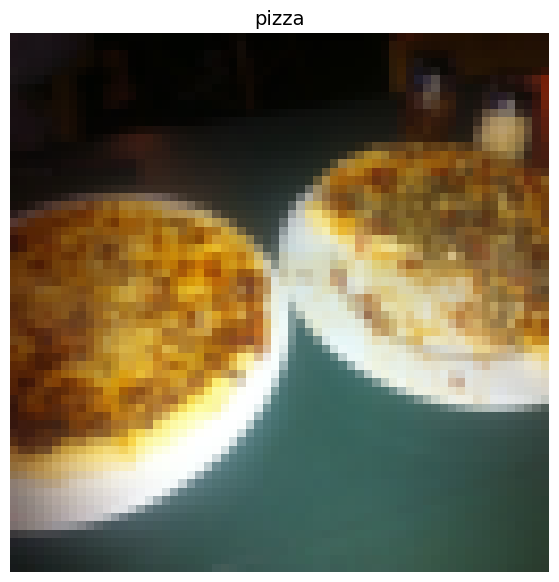

In [73]:
plt.figure(figsize=(10, 7))                   # Plot the image
plt.imshow(image_tensor_0.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label_0], fontsize=14);

Notice the image is now **more pixelated (less quality)** due to being resized from `512x512` to `64x64` pixels.
The intuition here is that if we think the image is **harder to recognize**, a model will find it **harder to understand** too.

## **2.5. Turning Torch Dataset Into DataLoader**

The DataLoader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)) wraps around a dataset object (such as `ImageFolder`) and provides an **iterable over the dataset, yielding batches of data** for training or evaluation.

Now let's turn the previous train and test sets into DataLoader.

* **Loading Train Dataset into Train DataLoader**: train_data  -> train_dataloader

In [74]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
NUM_WORKERS = 1

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,   # how many samples per batch?, now just 1 for simplicity
                              num_workers = NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle = True)            # shuffle the data?
train_dataloader

* **Loading the Test Dataset into the Test Data Loader**: test_data -> test_dataloader

In [75]:
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)           # don't usually need to shuffle testing data

test_dataloader

Now the the train and test DataLoaders are both **iterable**. Let's try inspect some attributes from these instances.

In [76]:
len(train_dataloader), len(test_dataloader)

(225, 75)

Since we used a batch size of 1, **number of batches** in the training DataLoader is the same with the **number of training samples**. It is the same for the testing samples too.

In [77]:
list(train_dataloader)[0] # image tensor, label

[tensor([[[[0.8078, 0.6863, 0.5961,  ..., 0.3255, 0.3412, 0.3608],
           [0.8000, 0.7529, 0.6235,  ..., 0.3216, 0.3725, 0.4118],
           [0.7843, 0.7686, 0.6784,  ..., 0.5647, 0.4980, 0.4706],
           ...,
           [0.3412, 0.3490, 0.3490,  ..., 0.3333, 0.3451, 0.3412],
           [0.3569, 0.3647, 0.3529,  ..., 0.3412, 0.3490, 0.3412],
           [0.3765, 0.3608, 0.3647,  ..., 0.3529, 0.3569, 0.3333]],
 
          [[0.8627, 0.7725, 0.7020,  ..., 0.2392, 0.1843, 0.1725],
           [0.8510, 0.8275, 0.7255,  ..., 0.2471, 0.2353, 0.2196],
           [0.8392, 0.8314, 0.7725,  ..., 0.5137, 0.4157, 0.3569],
           ...,
           [0.1725, 0.1804, 0.1765,  ..., 0.2784, 0.2784, 0.2549],
           [0.1765, 0.1843, 0.1765,  ..., 0.2824, 0.2863, 0.2510],
           [0.1882, 0.1843, 0.1843,  ..., 0.2980, 0.2941, 0.2431]],
 
          [[0.9922, 0.8863, 0.8078,  ..., 0.2392, 0.1765, 0.1569],
           [0.9922, 0.9529, 0.8431,  ..., 0.2471, 0.2196, 0.2078],
           [0.9765, 0.96

In [78]:
print(f"Batch 1:\n{next(iter(train_dataloader))}")
print(f"Batch 2:\n {next(iter(train_dataloader))}")
print(f"Batch 3:\n {next(iter(train_dataloader))}")

Batch 1:
[tensor([[[[0.2745, 0.1529, 0.1255,  ..., 0.4549, 0.4667, 0.5569],
          [0.2510, 0.1608, 0.1529,  ..., 0.4353, 0.4235, 0.4431],
          [0.1686, 0.1412, 0.1686,  ..., 0.3451, 0.3333, 0.3294],
          ...,
          [0.9059, 0.9137, 0.9216,  ..., 0.9608, 0.9569, 0.9529],
          [0.9020, 0.9137, 0.9216,  ..., 0.9569, 0.9569, 0.9529],
          [0.9020, 0.9137, 0.9216,  ..., 0.9569, 0.9529, 0.9490]],

         [[0.2431, 0.1020, 0.0784,  ..., 0.4627, 0.4706, 0.5725],
          [0.2118, 0.0980, 0.0941,  ..., 0.4431, 0.4196, 0.4353],
          [0.1255, 0.0902, 0.0980,  ..., 0.3412, 0.3216, 0.3098],
          ...,
          [0.9608, 0.9686, 0.9725,  ..., 1.0000, 0.9961, 0.9922],
          [0.9569, 0.9686, 0.9725,  ..., 0.9961, 0.9961, 0.9922],
          [0.9569, 0.9647, 0.9725,  ..., 0.9961, 0.9922, 0.9882]],

         [[0.2000, 0.0392, 0.0157,  ..., 0.5412, 0.5686, 0.6902],
          [0.1490, 0.0275, 0.0157,  ..., 0.5098, 0.4745, 0.4980],
          [0.0510, 0.0157, 0.015

In [79]:
image_tensor, label = next(iter(train_dataloader))

print(f"Image shape: {image_tensor.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


**Notes**:

> The data loader **adds  a `batch size` dimension** to the shape of the dataset:

        `[batch_size, color_channels, height, width] <- [color_channels, height, width]`

> Batch size is set to be 1, try changing the `batch_size` parameter above, say to 32, and see what happens.

> The `num_workers` defines **how many subprocesses** will be created to load the data (higher `num_workers`, **more compute power** to load data). It is usually set to the **total number of CPUs** by counting via Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count). This ensures the `DataLoader` recruits as many cores as possible to load data.

In [80]:
os.cpu_count()

2

In [ ]:
# BATCH_SIZE = 1
# NUM_WORKERS = os.cpu_count()
# train_dataloader = DataLoader(dataset = train_data,
#                               batch_size = BATCH_SIZE,
#                               num_workers = NUM_WORKERS,
#                               shuffle = True)
# test_dataloader = DataLoader(dataset = test_data,
#                              batch_size = BATCH_SIZE,
#                              num_workers = NUM_WORKERS,
#                              shuffle = False)           # don't usually need to shuffle testing data

# train_dataloader, test_dataloader




Let's look at another option to load images (or almost any other kind of data).

#**3. Custom Replication of Functionality of `ImageFolder`: Option 2**

Some of the pros and cons of creating datasets in a custom way:

| Pros  | Cons  |
| ----- | ----- |
| Can create a torch dataset out of almost anything. | A dataset out of almost anything does not mean it will work. |
| Not limited to PyTorch pre-built dataset functions. | Often results in more code, hence prone to errors or performance issues. |

In [81]:
import os
import pathlib
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

## **3.1. Custom Function to Find Classes in a Directory**

Remember how to use the `classes` and `class_to_idx` attributes in the instance of `torchvision.datasets.ImageFolder()` .

In [82]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

With this in mind, let us define a function to create a **list** and a **dictionary** of classes in given a directory. To do so, :
1. Get **classes** using `os.scandir()` to traverse a target directory which is ideally in a **standard image classification format**.
2. Raise an **error** if the classes are **not found because of something wrong** in the directory structure.
3. Turn **classes** into a **dictionary** of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [86]:
target_directory = train_dir                                                         # Setup path for target directory
print(f"Target directory: {target_directory}")
class_names = sorted([entry.name for entry in list(os.scandir(image_path/"train"))]) # Get the class names from the target directory
print(f"Classes found: {class_names}")

Target directory: data/pizza_steak_sushi/train
Classes found: ['pizza', 'steak', 'sushi']


Let us make the function to find classes in a given target directory.

In [87]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()) # 1. Get the class names by scanning the target directory
    if not classes:                                                                   # 2. Raise an error if class names not found
        raise FileNotFoundError(f"Could not find any classes in {directory}.")
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}             # 3. A dict of index labels (computers prefer numerical rather than string labels)
    return classes, class_to_idx

Now let's test out the `find_classes()` function.

In [88]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Looking good!

## **3.2. Define a Custom Dataset Class**

We are working towards replicating the functionality of `torchvision.datasets.ImageFolder()` in a custom way. A few of the required steps:
1. Subclass `torch.utils.data.Dataset` (the base class for all datasets in PyTorch).
2. Initialize the subclass with the `targ_dir` target data directory and the optional `transform` parameters.
3. Create several attributes:
  * `paths` - pathes of images,
  * `transform` - transformation to be made (can be `None`),
  * `classes` -  a list of target classes
  * `class_to_idx` - a dict of target classes mapped to integer labels.
4. Create a function `load_images()` to load images from file and then open it in return.
5. Overwrite the `__len__` method to return **number of samples** in the dataset (**recommended but not required**).
6. Overwrite the `__getitem__` method **to return a single sample** from the dataset (**required**).

Let's do it!

In [89]:
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):                                 # 1. Subclass torch.utils.data.Dataset to inherits from
    def __init__(self, targ_dir: str, transform = None) -> None:  # 2. Initialize with a targ_dir and transform (optional) parameter
                                                                  # 3. Create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # Get all image paths; must update this: .png's or .jpeg's
        self.transform = transform                                # Setup transforms
        self.classes, self.class_to_idx = find_classes(targ_dir)  # Create classes and class_to_idx attributes

    def load_image(self, index: int) -> Image.Image:              # 4. Make function to load images
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:                                     # 5. Overwrite the __len__() method (optional but recommended)
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: # 6. Overwrite the __getitem__() method (required)
        image_tensor = self.load_image(index)
        class_name  = self.paths[index].parent.name                # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
        if self.transform:                                         # Transform if necessary
            return self.transform(image_tensor), class_idx         # return (data, label) = (X, y)
        else:
            return image_tensor, class_idx                         # return (data, label) = (X, y)

A whole bunch of code to load in the images. This is **one of the downsides** of creating a custom `Dataset`.

We could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

## **3.3. Create an Instance of the Custom Dataset**

Let's create some transforms to prepare the images and then test out on the new `ImageFolderCustom` class.

In [90]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),   # Augment train data
    transforms.ToTensor()
    ])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),                # Don't augment test data, only reshape
    transforms.ToTensor()
    ])

Now comes the moment of truth!
Let's turn the training images (contained in `train_dir`) and the testing images (contained in `test_dir`) into torch dataset using our own custom `ImageFolderCustom` class.

In [91]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c187ab29240>,
 <__main__.ImageFolderCustom at 0x7c187ab28880>)

No errors, it did work.

## **3.4. Inspect the Main Attributes of the Dataset**

Let's try calling `len()` on the new `Dataset`'s and find the `classes` and `class_to_idx` attributes.

In [92]:
len(train_data), len(train_data_custom)

(225, 225)

In [93]:
len(test_data), len(test_data_custom)

(75, 75)

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

In [94]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}


It looks like it worked.
We could check for equality with the `Dataset`'s made by the `torchvision.datasets.ImageFolder()` class too.

Check for equality amongst the `custom` Dataset and `ImageFolder` Dataset

In [95]:
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Three `True`'s! Can't we get much better than that.

How about we take it up a notch and plot some random images to test the `__getitem__` override?

##  **3.5. Displaying Random Images**

Let's create a helper function called `display_random_images()` that helps to visualize some images from the dataset.

1. Inputs: Dataset, names of target classes, number of images to display (`n=10`) and a random seed (`seed=42`).
2. Get a list of random sample indexes to plot.
3. Loop through the random sample indexes found in step 2 and plot them. Here, make sure the sample images are of shape `HWC` (height, width, color channels) so we can use `matplotlib` for plotting.

In [96]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,                 # to see transformed shape
                          seed: int = None):                          # 1. Take in a Dataset as well as a list of class names
    if n > 10:
        n = 10
        display_shape = False # for not being overlapped and croweded
        print(f"For display purposes, n is set to 10 and shape displays are removed.")
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k = n)    # 2. Get random sample indexes
    plt.figure(figsize=(16, 8))                                       #  Setup plot
    for idx, image_idx in enumerate(random_samples_idx):              # 3. Loop through samples and display random samples
        image_tensor, label = dataset[image_idx][0], dataset[image_idx][1]
        image_tensor_adjust = image_tensor.permute(1, 2, 0)           # [H, W, C] <- [C, H, W]
        plt.subplot(1, n, idx + 1)                                    # Plot adjusted samples
        plt.imshow(image_tensor_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[label]}"
            if display_shape:
                title = title + f"\nShape: {image_tensor_adjust.shape}"
        plt.title(title)

Let's test it out first with the dataset we created using `torchvision.datasets.ImageFolder()`.

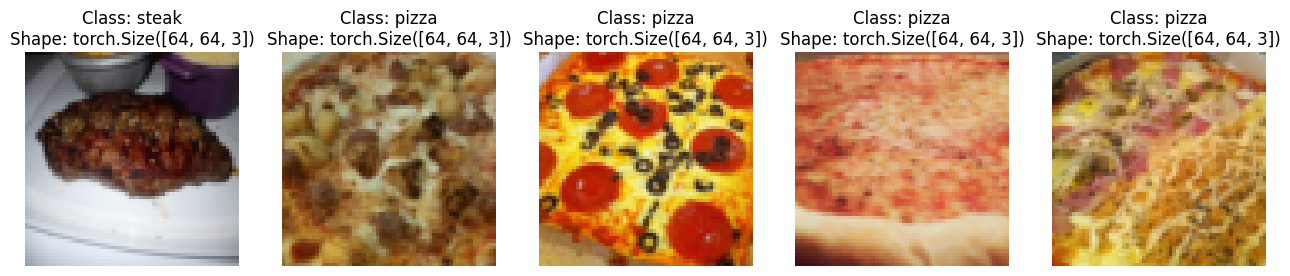

In [97]:
                                    # Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed = None)

And now with the dataset we created with our own custom `ImageFolderCustom` class.

For display purposes, n is set to 10 and shape displays are removed.


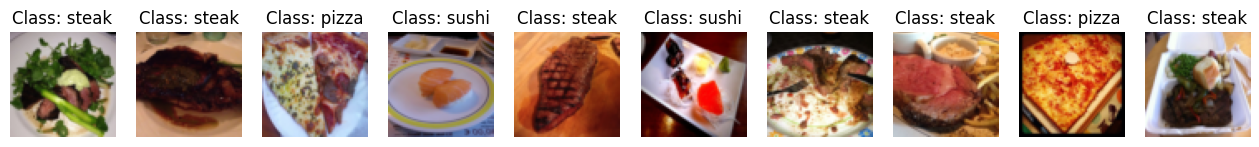

In [ ]:
                                # Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n = 12,
                      classes = class_names,
                      seed = None)

Looks like the custom `ImageFolderCustom` class is working just as we'd like it to.

## **3.6. Turning Torch Custom Datasets into DataLoaders**

Now how could we turn the custom datasets into data loaders? Because the custom datasets subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

In [98]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS,
                                    shuffle = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c187acaebc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c187a974c10>)

Do the shapes of the samples look the same?

In [99]:
image_tensor_custom, label_custom = next(iter(train_dataloader_custom)) # Get image and label from custom DataLoader
print(f"Image shape: {image_tensor_custom.shape} -> [batch_size, color_channels, height, width]") # Batch size will now be 1
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


They sure do! Let's now take a lot at some other forms of data transforms.

# **4. Model 0: TinyVGG Without Data Augmentation**

Now let's construct a computer vision model to see if we can classify if an image is of **pizza**, **steak** or **sushi** by replicating the TinnyVGG model from the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website..


### **1. Create Function for Transforms**

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    ])

### **2. Load Data to Torch**

#### **2.1. Turn to Torch Datasets**

Turn each of the training and test folders into a torch **Dataset** with `torchvision.datasets.ImageFolder()`

In [ ]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform) # Load and transform data
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)   # Load and transform data

train_data_simple, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

#### **2.2. Turn Datasets to DataLoaders**

Turn the **Datasets** into a **DataLoaders** using `torch.utils.data.DataLoader()`. Set the `batch_size=32` and `num_workers` to as many CPUs on the machine.

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dataloader_simple = DataLoader(train_data_simple,           # Create DataLoader
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,             # Create DataLoader
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f12e2ac5870>,
 <torch.utils.data.dataloader.DataLoader at 0x7f12e27bb880>)

The training and testing `DataLoader` instances are created!
Let's build a model.

### **3. Define and Instantiate TinyVGG Model**

We have already seen the TinyVGG model from the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website.
Let's recreate the same model, except this time we'll be using color images (`in_channels=3` for RGB pixels) instead of grayscale (`in_channels=1`).

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) # k-size=stride by default
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) # k-size=stride by default
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 0 * 0,
                      out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(f"Conv_block_1 output shape: {x.shape}.")
        x = self.conv_block_2(x)
        print(f"Conv_block_2 output shape: {x.shape}.")
        x = self.classifier(x)
        print(f"Classifier output shape: {x.shape}")
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=0, out_features=3, bias=True)
  )
)

How about we test it out with a forward pass on a single image?

### **4. Test Forward Pass on a Single Image**

A good way to test a model is to do a **forward pass on a single piece of data**.
It's also handy way to test the input and output shapes of the different layers.

#### **Inspecting Input and Output Shapes**

To do a forward pass on a single image, let's:
1. Get **a batch of images and labels** from the `DataLoader`.
2. Get a **single image** from the batch and `unsqueeze()` the image so its shape fits the model.
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Convert the model's **raw output logits to prediction probabilities** with `torch.softmax()` and convert the **prediction probabilities to prediction labels** with `torch.argmax()`.

In [ ]:
image_tensor_batch_0, label_batch_0 = next(iter(train_dataloader_simple))    # 1. Get a batch of images and labels from the DataLoader
image_tensor_batch_0.shape, label_batch_0.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
image_tensor_batch_0[0].shape, label_batch_0[0]

(torch.Size([3, 64, 64]), tensor(1))

In [ ]:
image_tensor_0, label_0 = image_tensor_batch_0[0].unsqueeze(dim = 0), label_batch_0[0] # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
print(f"Single image shape: {image_tensor_0.shape}, label: {label_batch_0[0]}.\n")

Single image shape: torch.Size([1, 3, 64, 64]), label: 1.



In [ ]:
# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(image_tensor_0.to(device))     # 3. Perform a forward pass on a single image

#                                   # 4. Convert model logits -> pred probs -> pred label
# print(f"Predicted logits:\n{pred}\n")
# print(f"Predicted probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Predicted label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_0}")

The shape of output of `conv_block_1` is `torch.Size([1, 10, 32, 32])` and that of `conv_block_2` is `torch.Size([1, 10, 16, 16])` where the shapes represent `[B, C, H W]` and 1 is the batch size for a single image.

`The RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2560 and 0x3)`

This indicates that the shape of the input of the output (classifier layer) should be `10x16x16=2560`.

We can also pass a batch of images and see the same error.

In [ ]:
# model_0.eval()
# with torch.inference_mode():
#     pred = model_0(image_tensor_batch_0.to(device))     # 3. Perform a forward pass on a batch of image tensors

#                                   # 4. Convert model logits -> pred probs -> pred label
# print(f"Predicted logits:\n{pred}\n")
# print(f"Predicted probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Predicted label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_batch_0}")

The shape of output of `conv_block_1` is `torch.Size([32, 10, 32, 32])` and that of `conv_block_2` is `torch.Size([32, 10, 16, 16])` where the batch size is now 32.

`RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 0x3)`

This indicates that the shape of the input of the output (classifier layer) should be `10x16x16=2560`.


Following code includes the appropriate input shapes of the final output layer.

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) # k-size=stride by default
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) # k-size=stride by default
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 16 * 16,
                      out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(f"Conv_block_1 output shape: {x.shape}.")
        x = self.conv_block_2(x)
        print(f"Conv_block_2 output shape: {x.shape}.")
        x = self.classifier(x)
        print(f"Classifier output shape: {x.shape}")
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(image_tensor_batch_0.to(device))     # 3. Perform a forward pass on a batch of image tensors

                                  # 4. Convert model logits -> pred probs -> pred label
# print(f"Predicted logits:\n{pred}\n")
# print(f"Predicted probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Predicted label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_batch_0}")

Conv_block_1 output shape: torch.Size([32, 10, 32, 32]).
Conv_block_2 output shape: torch.Size([32, 10, 16, 16]).
Classifier output shape: torch.Size([32, 3])


Wonderful, it looks like the model is outputting what we'd expect it to output. Running the cell above each time have a different image be predicted on in which the predictions are often wrong. This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

**Note**: The shapes of the TinnyVGG model of `conv_block_1` output is `[30, 30, 10]` and `conv_block_2` is `[13, 13, 10]`) keeping in mind that color channels are first in PyTorch. To exactly replicate it, we can set  `padding = 0` in all convolutional layers. Also remember to adjust the in-features of the output layer accordingly.

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # k-size=stride by default
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # k-size=stride by default
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 13 * 13,
                      out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(f"Conv_block_1 output shape: {x.shape}.")
        x = self.conv_block_2(x)
        print(f"Conv_block_2 output shape: {x.shape}.")
        x = self.classifier(x)
        print(f"Classifier output shape: {x.shape}")
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(image_tensor_batch_0.to(device))     # 3. Perform a forward pass on a batch of image tensors

                                  # 4. Convert model logits -> pred probs -> pred label
# print(f"Predicted logits:\n{pred}\n")
# print(f"Predicted probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Predicted label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_batch_0}")

Conv_block_1 output shape: torch.Size([32, 10, 30, 30]).
Conv_block_2 output shape: torch.Size([32, 10, 13, 13]).
Classifier output shape: torch.Size([32, 3])


#### **Model Summary Using `torchinfo`**

Printing out the model with `print(model)` gives us an idea of what's going on with the model.
And we can print out the shapes of the data throughout the `forward()` method.
However, a helpful way to get information from the model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo) which comes with a `summary()` method that takes a PyTorch model as well as an `input_shape`.

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

The output of `torchinfo.summary()` gives us a whole bunch of information about the model such as `Total params`, the total number of parameters in the model, the `Estimated Total Size (MB)` which is the size of the model.

In [ ]:
torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

Conv_block_1 output shape: torch.Size([1, 10, 30, 30]).
Conv_block_2 output shape: torch.Size([1, 10, 13, 13]).
Classifier output shape: torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

The aobve output shows the `TinnyVGG` model comprizes of 3 sequential blocks. And inside each block, there are different combinations of layers (Conv, ReLU and MaxPool Layers) and the final block contains a flatten layer and a linear layer.
We can also see the changes in the input and output shapes as data of a certain `input_size` moves through the model.

#### **Operator Fusion**

In a neural network, each of the sequential operations introduces some overhead due to memory transfers, intermediate data storage, and function call overhead.
**Operator fusion**, also known as **kernel fusion** or **operation fusion**, is a technique of combining multiple operations or operators into a single operation, reducing the number of individual operations that need to be executed.

For example, the `forward()` method in the model above of calls a layer block and reassigns `x` every time:
```
def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x
```
In stead of going from computation back to memory every time, we call each block of the `forward()` method in succession as shown below.
```
def forward(self, x: torch.Tensor):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
```
Operator fusion saves the time spent reassigning `x` (memory heavy), eliminates redundant memory transfers and minimizs the intermediate storage and focuses on only computing on `x`. More on [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # k-size=stride by default
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # k-size=stride by default
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 13 * 13,
                      out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### **5. Functionalizing Train and Test Loops Together**

We've got data and we've got a model.
Now let's make some training and test loop functions to train the model on the training data and evaluate the model on the testing data.
And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a **Model**, a training **DataLoader**, a **Loss** function, an **Optimizer**, ..., and then trains the model.
2. `test_step()` - takes in a **Model**, a testing **DataLoader**, a **Loss** function, ..., and then evaluates the model.
3. `train()` - performs `train_step()` and `test_step()` together for a given number of epochs and returns a results dictionary.

#### **1. Functionalize Training Loop: `train_step()`**

Let's start by building `train_step()`.
Because we're dealing with batches in the DataLoaders, we'll accumulate the model loss and accuracy values during training and then adjust for each epoch.

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device = device):
    model.train()                                         # Put model in train mode
    train_loss, train_acc = 0, 0                          # Setup train loss and train accuracy values
    for batch_idx, (X, y) in enumerate(dataloader):       # Loop through data loader data batches
        X, y = X.to(device), y.to(device)                 # Send data to target device
        logit_preds = model(X)                                # 1. Forward pass
        loss = criterion(logit_preds, y)                      # 2. Calculate  and accumulate loss
        train_loss += loss.item()
        optimizer.zero_grad()                             # 3. Optimizer zero grad
        loss.backward()                                   # 4. Loss backward
        optimizer.step()                                  # 5. Optimizer step
                                                          # Calculate and accumulate accuracy metric for all batches
        prob_preds = torch.softmax(logit_preds, dim=1)
        y_preds = torch.argmax(prob_preds, dim=1)
        train_acc += (y_preds == y).sum().item() / len(y_preds)
    train_loss = train_loss / len(dataloader)             # Get average loss per batch
    train_acc = (train_acc / len(dataloader)) * 100       # Get average accuracy per batch
    return train_loss, train_acc

####**2. Functionalize Testing Loop: `test_step()`**

Now let's do the same for the `test_step()` function.
The main differences are 1) the `test_step()` won't take in an optimizer and therefore won't perform gradient descent, and 2) we'll make sure to put the model in `.eval()` mode and make predictions turning the `torch.inference_mode()` context manager on.

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device = device):
    model.eval()                                                    # Put model in eval mode
    test_loss, test_acc = 0, 0                                      # Setup test loss and test accuracy values
    with torch.inference_mode():                                    # Turn on inference context manager
        for batch_idx, (X, y) in enumerate(dataloader):             # Loop through DataLoader batches
            X, y = X.to(device), y.to(device)                       # Send data to target device
            logit_preds = model(X)                                  # 1. Forward pass
            loss = criterion(logit_preds, y)                        # 2. Calculate and accumulate loss
            test_loss += loss.item()
            y_preds = logit_preds.argmax(dim=1)                     # Calculate and accumulate accuracy
            test_acc += ((y_preds == y).sum().item() / len(y_preds))
    test_loss = test_loss / len(dataloader)                         # Get average loss  per batch
    test_acc = (test_acc / len(dataloader)) * 100                   # Get average accuracy per batch
    return test_loss, test_acc

#### **3. A `train()` Function Packaging `train_step()` and `test_step()` Functions**

Now we need a way to put the `train_step()` and `test_step()` functions together.
To do so, we'll package them up in a `train()` function which will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a **Model**, train and test **DataLoaders**, a **Loss** function, an **Optimizer**, number of **epochs**, and other parameters required.
2. Initialize an empty metrics dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values.
3. Loop through the training and test step functions for the specified number of epochs.
4. Update results dictionary with the updated metrics at each epoch.
5. Return the results dictionary.

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm).

In [ ]:
from tqdm.auto import tqdm
                                                              # 1. Take in parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
                                                              # 2. Create empty results dictionary
    metrics_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
                                                              # 3. Loop through training and testing steps for each epoch
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           criterion = criterion,
                                           optimizer = optimizer,
                                           device =  device)
        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        criterion = criterion,
                                        device = device)
                                                              # 4. Update results dictionary
        metrics_dict["train_loss"].append(train_loss)
        metrics_dict["train_acc"].append(train_acc)
        metrics_dict["test_loss"].append(test_loss)
        metrics_dict["test_acc"].append(test_acc)
        print(
            f"Epoch: {epoch} | "
            f"Train: loss = {train_loss:.4f}, "
            f"accuracy = {train_acc:.2f}% | "
            f"Test: loss = {test_loss:.4f}, "
            f"accuracy = {test_acc:.2f}%"
            )
    return metrics_dict                                        # 5. Return results at the end of the epochs

### **6. Train and Test Model**

Time to put the `TinyVGG` model, DataLoaders and `train()` function together to see if we can build a model capable of discerning between **pizza**, **steak** and **sushi**!

To keep the experiments quick, we'll train the model for **5 epochs**.
As for a **loss** function and an **optimizer**, we'll use `torch.nn.CrossEntropyLoss()` (since working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `0.001` respecitvely.
To see how long things take, we'll use the Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) method to calculate the training time.

In [ ]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape = 3, # number of color channels (3 for RGB)
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

start_time = timer()
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        criterion = criterion,
                        epochs = NUM_EPOCHS)
end_time = timer()

print(f"Training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train: loss = 1.1063, accuracy = 30.47% | Test: loss = 1.0983, accuracy = 29.07%
Epoch: 2 | Train: loss = 1.0995, accuracy = 33.20% | Test: loss = 1.0699, accuracy = 54.17%
Epoch: 3 | Train: loss = 1.0863, accuracy = 49.22% | Test: loss = 1.0800, accuracy = 52.27%
Epoch: 4 | Train: loss = 1.0824, accuracy = 41.02% | Test: loss = 1.0600, accuracy = 57.29%
Epoch: 5 | Train: loss = 1.0629, accuracy = 41.41% | Test: loss = 1.0606, accuracy = 55.40%
Training time: 10.411 seconds


It looks like the model performed pretty poor.
That's okay for now, we'll keep persevering.

### **7. Loss Evaluation**

#### **Loss Curves**

A **loss curve** is a graphical representation of the loss values on different datasets (e.g. training and test) over time (the course of training a machine learning model).
Monitoring the loss curve is a common practice in machine learning to assess the **model's performance**, detect issues like **overfitting** or **underfitting**, and guide decisions on **when to stop training** or **adjust hyperparameters**.

An overfitting model is one that **performs better on the training set** but not on the validation/test set (the test/validation loss is higher than the training loss).
If the training loss is far lower than the test loss, the model is **overfitting**. Learning the patterns in the training too well is not generalizing to the test data.

The other side is when the training and test loss are not as low as required, this is considered **underfitting**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

The ideal scenario is when the training and test loss curves line up over time. This means the model is generalizing well. There are more combinations and different patterns loss curves can do, see [Interpreting Loss Curves](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic) guide.

From the print outs of `model_0` training, it didn't look like it did well. We can further evaluate it by plotting the model's **loss curves**.

In [ ]:
model_0_results

{'train_loss': [1.106342926621437,
  1.0995028167963028,
  1.0862611085176468,
  1.082399621605873,
  1.0628651976585388],
 'train_acc': [30.46875, 33.203125, 49.21875, 41.015625, 41.40625],
 'test_loss': [1.09831702709198,
  1.0698525508244832,
  1.0799858967463176,
  1.0600422223409016,
  1.060593883196513],
 'test_acc': [29.071969696969695,
  54.166666666666664,
  52.27272727272728,
  57.291666666666664,
  55.39772727272728]}

Let's create a function to plot the values in the `model_0_results` dictionary.

In [ ]:
model_0_results.keys() # Check the model_0_results keys

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll need to extract each of these keys and turn them into a plot.

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']                      # Get train losses
    test_loss = results['test_loss']                  # Get test losses

    accuracy = results['train_acc']                   # Get train accuracies
    test_accuracy = results['test_acc']               # Get test accuracies

    epochs = range(1, len(results['train_loss']) + 1) # Number of epochs

    plt.figure(figsize=(15, 7)) # Setup a plot
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = 'Train')
    plt.plot(epochs, test_loss, label = 'Test')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'Train')
    plt.plot(epochs, test_accuracy, label = 'Test')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend();

Okay, let's test the `plot_loss_curves()` function out.

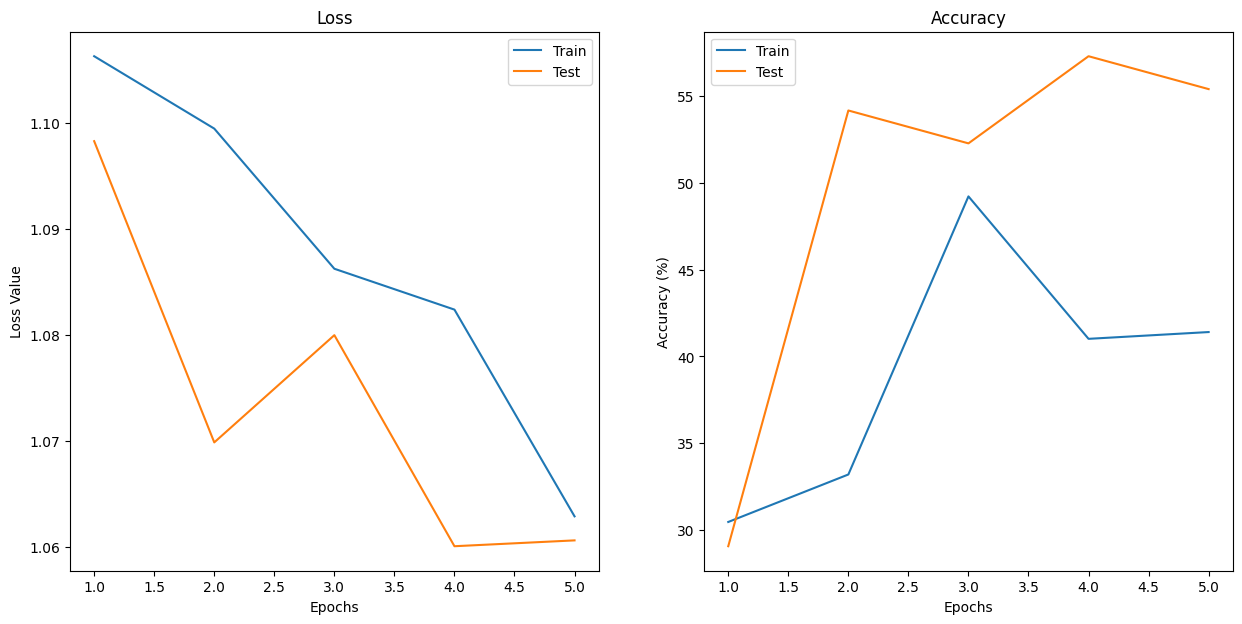

In [ ]:
plot_loss_curves(model_0_results)

Good start. We could try training the model for longer and see what happens when we plot a loss curve over a longer time horizon.

#### **Dealing With Overfitting**

Since the main problem with overfitting is that the model is fitting the training data **too well**. Need to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html). Think of this as "making the models more regular", as in, capable of fitting **more kinds of data**.

| **Solution Method** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify model** | Reduce the number of layers or to reduce the number of hidden units in each layer. |
| **[Augment data](https://developers.google.com/machine-learning/glossary#data-augmentation)** | It adds more variety to the data, the model may be able to generalize better to unseen data. |
|[**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) |  Leveraging the patterns of a model (also called pretrained weights) as a foundation for a particular task, and adjusting them to be more specialized to that specfic problem. |
| [**Dropout layers**](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) | Randomly remove connections between hidden layers in neural networks, but also makes the remaining connections better. |
| **[Learning rate decay](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)** | Slowly decrease the learning rate as a model trains. The closer to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller weight updates to be.  |
| [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) |  Stops model training **before it begins to overfit**. |

Dealing with overfitting is one of the primary problems of deep learning. There are more methods for dealing with overfitting.



#### **Dealing With Underfitting**

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have **poor predictive power** on the training and test sets.
In essence, an underfitting model will fail to reduce the loss values to a desired level.

| **Solutiuon Method** | **What is it?** |
| ----- | ----- |
| **Add more layers/units** | Increase the number of hidden layers/units to make the model have enough capability to learn the required patterns/weights/representations of the data. |
| **Tweak learning rate** | If the model is trying to update its weights too much in each epoch, in turn not learning anything. In this case, lower the learning rate and see what happens. |
| **Transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. |
| **Less regularization** | Holding back on regularization techniques can help the model fit the data better. |

The main idea behind dealing with underfitting is to **increase the model's predictive power**.

#### **Balance Between Overfitting and Underfitting**

None of the methods discussed above are silver bullets, meaning, they don't always work.
And preventing overfitting and underfitting is possibly the most active area of machine learning research.
Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).
There's a fine line between overfitting and underfitting.
Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on certain problems.
Rather than handcraft different overfitting and underfitting techniques, transfer learning enables to take an already working model in a similar problem space to ours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota)) and apply it to our own dataset.

# **5. Model 1: TinyVGG With Data Augmentation**


Right now, looking at the loss curves of the `TinyVGG` model, it seems `model_0` is underfitting the data.

Time to try out another model! This time, we will use **data augmentation** to see if it improves the results in anyway.

### **1. Create Transform With Augmentation**


First, let us compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turning images into tensors. We'll do the same for a testing transform except without the data augmentation.

In [ ]:
                                # Training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])
                                # Testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
    ])

### **2. Convert Image Folders to Datasets and DataLoaders**


Now let's turn the images into Torch **Datasets** using `torchvision.datasets.ImageFolder()` and then into **DataLoaders** with `torch.utils.data.DataLoader()`.
Make sure the train dataset uses `train_transform_trivial_augment` and the test dataset uses  `test_transform`.

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

And we'll make DataLoaders with a `batch_size=32` and with `num_workers` set to the number of CPUs available on the machine (we can get this using Python's `os.cpu_count()`).

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f12e2420fa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f12e2d2ce50>)

### **3. Create a New Model Instance**

Data loaded! Now to build our next model, `model_1` with similar architecture with `model_0` (TinnyVGG). The only difference is now we are going to use an augmented training data.

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Model ready! Time to train!

### **4. Train and Test Model**

We'll use the same training setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `train_dataloader = train_dataloader_augmented` as the training data in `train()`.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
* Use `torch.optim.Adam()` with `lr = 0.001` as the optimizer.                                                          

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


NUM_EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        criterion =criterion,
                        epochs = NUM_EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train: loss = 1.1049, accuracy = 25.00% | Test: loss = 1.1019, accuracy = 26.04%
Epoch: 2 | Train: loss = 1.0807, accuracy = 42.58% | Test: loss = 1.1261, accuracy = 26.04%
Epoch: 3 | Train: loss = 1.0713, accuracy = 42.58% | Test: loss = 1.1594, accuracy = 26.04%
Epoch: 4 | Train: loss = 1.1256, accuracy = 30.47% | Test: loss = 1.1580, accuracy = 26.04%
Epoch: 5 | Train: loss = 1.0845, accuracy = 42.58% | Test: loss = 1.1543, accuracy = 31.25%
Total training time: 8.765 seconds


It doesn't look like the model performed well again.
Let's check out its loss curves.

### **5. Evaluating Model**

#### **Examining Loss Curves**

Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

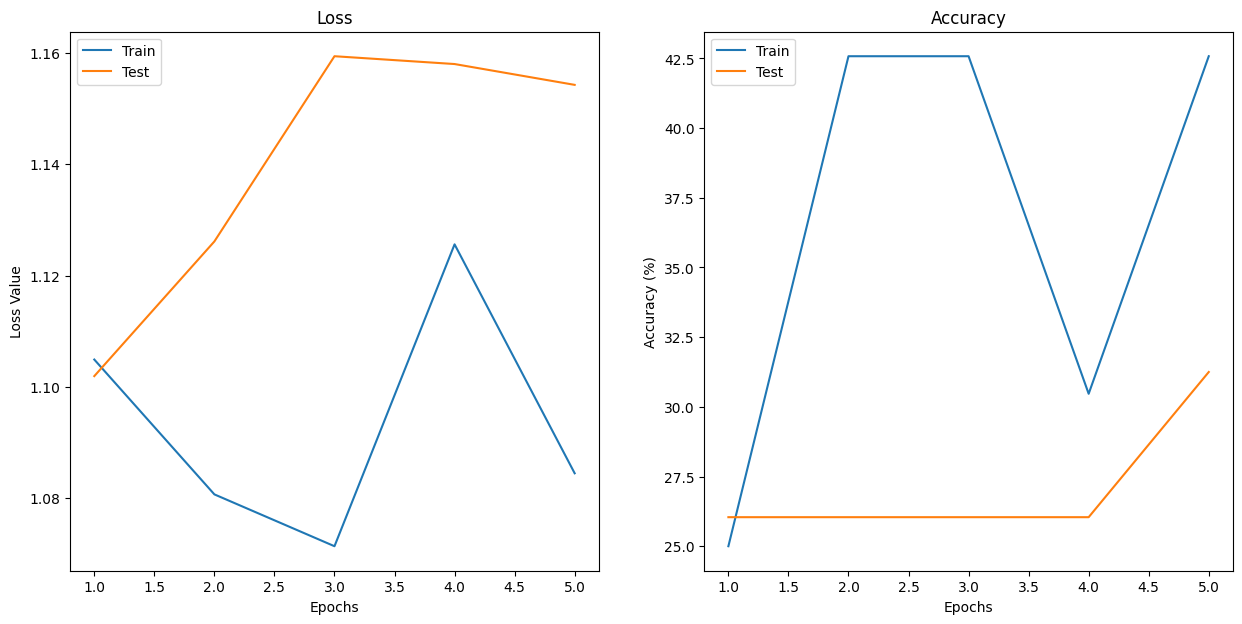

In [ ]:
plot_loss_curves(model_1_results)

Is the model **underfitting** or **overfitting**?
Ideally we'd like it have higher accuracy and lower loss.
What are some methods we could try to use to achieve these?

#### **Compare Model Results**

After evaluating the modelling experiments on their own, it is important to compare them to each other.  There are a few different ways to do this:
1. Hard coding (what we were and are doing).
2. [PyTorch + TensorBoard](https://pytorch.org/docs/stable/tensorboard.html#module-torch.utils.tensorboard)
3. [Weights & Biases](https://wandb.ai/site/experiment-tracking)
4. [MLFlow](https://mlflow.org/)


Let's first turn the model results in pandas DataFrames.

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss   test_acc
0    1.106343  30.468750   1.098317  29.071970
1    1.099503  33.203125   1.069853  54.166667
2    1.086261  49.218750   1.079986  52.272727
3    1.082400  41.015625   1.060042  57.291667
4    1.062865  41.406250   1.060594  55.397727

And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

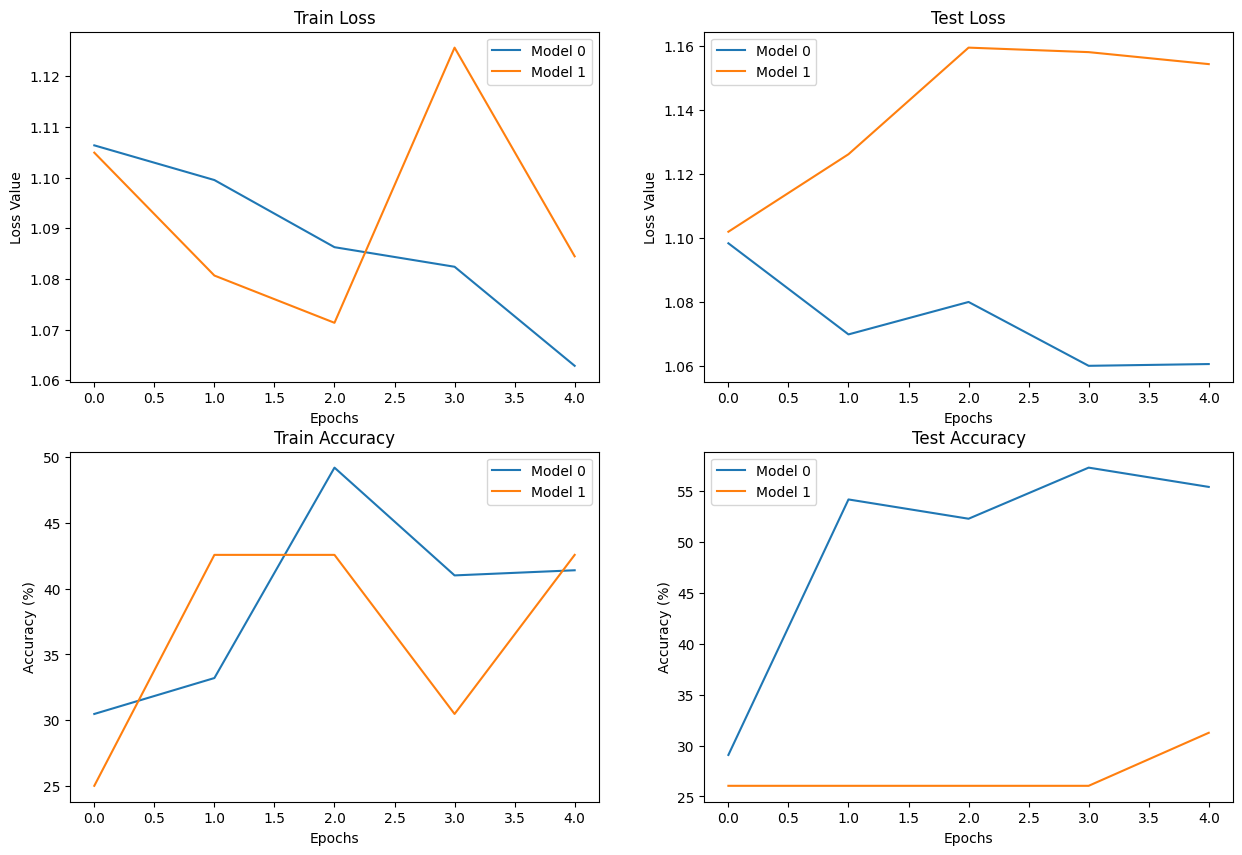

In [ ]:
plt.figure(figsize=(15, 10)) # Setup a plot
epochs = range(len(model_0_df)) # Get number of epochs

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss Value')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss Value')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy (%)')
plt.legend();

It looks like the models both performed poorly and were kind of sporadic (the metrics go up and down sharply).

If you built `model_2`, what would you do differently to try and improve performance?

### **6. Make Prediction on a Custom Image**

Since we've trained a model on pizza, steak and sushi images, how could we use the model to make a prediction on one of our own images?
To do so, we can load an image and then preprocess it to match the **data type** and **shape** that the model was trained on, and should also be on **right device** before passing it to the model.
Let's download a photo of [someone giving two thumbs up to a big pizza](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) using Python's `requests` module.

> **Note:** In Google Colab, we can also upload an image by going to the left hand side menu -> **Files -> Upload to session storage**. Beware though, this image will be deleted when the session ends.


In [ ]:
import requests
custom_image_path = data_path/"04-pizza-dad.jpeg" # Setup custom image path

if not custom_image_path.is_file():             # Download the image if it doesn't already exist
    with open(custom_image_path, "wb") as f:    # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
        print(f"{custom_image_path} download finished.")
else:
    print(f"{custom_image_path} already exists.")

data/04-pizza-dad.jpeg already exists.


Looks like we've got the image downloaded and ready to go at `data/04-pizza-dad.jpeg`.

#### **Loading Image With `torchvision.io`**

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).
Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.
Let's try it out.

In [ ]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)) # Read in custom image
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

It looks like the image is in tensor format. Specifically it is of `torch.uint8` datatype and its values are between `[0, 255]`.
Let's plot the image with `matplotlib` to make sure it looks okay. Remember to permute the dimensions from `CHW` to `HWC` for compatibility with `matplotlib` requirements.

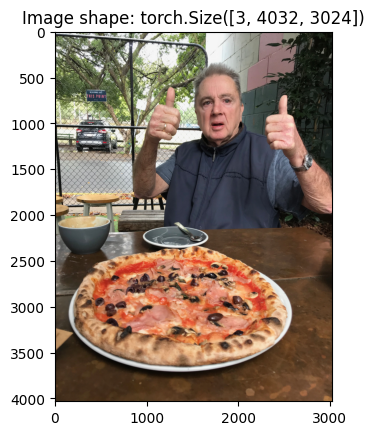

In [ ]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image_uint8.shape}");
# plt.axis(False);

Now let us make a prediction on the image with `uint8` format.

In [ ]:
model_1.eval()
with torch.inference_mode():
    image_pred_tensor = model_1(custom_image_uint8.to(device))

image_pred_tensor

RuntimeError: ignored

What causes the above error? The image tensor is of datatype `torch.uint8` and its values are between `[0, 255]`.
But the model is trained on image tensors of datatype `torch.float32` and with values between `[0, 1]`.

That is why we get the  `RuntimeError` like the following because the image format is not compatible with the data that the model was trained.
> `RuntimeError: Input type (unsigned char) and bias type (float) should be the same`
or
> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

So we need to convert it to the **same data type** as the data the model is trained on**.
Let's fix this.

In [ ]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image_flt = custom_image / 255 # Divide the image pixel values by 255 to get them between [0, 1]

# Print out image data
print(f"Custom image tensor:\n{custom_image_flt}\n")
print(f"Custom image shape: {custom_image_flt.shape}\n")
print(f"Custom image dtype: {custom_image_flt.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

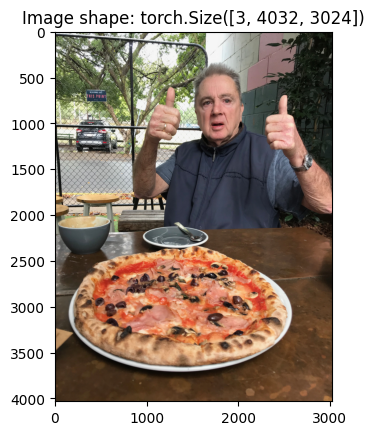

In [ ]:
plt.imshow(custom_image_flt.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image_flt.shape}");
# plt.axis(False);

It looks like the image data is now in the **same data type** the model was trained on. We have got also same image.

So let us try prediction.

In [ ]:
model_1.eval()
with torch.inference_mode():
    image_pred_tensor = model_1(custom_image_flt.to(device))

image_pred_tensor

RuntimeError: ignored

  Another `RuntimeError` concerning shape. Notice the **shape** of the image is `[3, 4032, 3024]` which is very large. However, the model was trained on images of shape `[3, 64, 64]`. How could we adjust the image shape to be the same with shape of the images the model was trained on? One way to do so is with `torchvision.transforms.Resize()`.

In [ ]:
custom_image_transformed = transforms.Resize((64, 64))(custom_image_flt)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


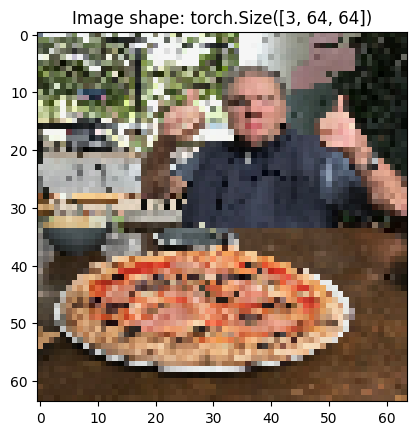

In [ ]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image_transformed.shape}");
# plt.axis(False);

The image is pixelated too because we resized from `[4032, 3024]` to `[64, 64]`.


Now try prediction.

In [ ]:
model_1.eval()
with torch.inference_mode():
    image_pred_tensor = model_1(custom_image_transformed.to(device))

image_pred_tensor

RuntimeError: ignored

There's one dimension we forgot about. The batch size.
The model expects image tensors with a batch size dimension at the start (`NCHW` where `N` is the batch size).

Except the custom image is currently only `CHW`.
We can add a batch size dimension using `torch.unsqueeze(dim=0)` to add an extra dimension our image and finally make a prediction.
Essentially we'll be telling the model to predict on a single image (an image with a `batch_size` of 1).

We need to add a batch size to solve the above error.

In [ ]:
model_1.eval()
with torch.inference_mode():
    image_pred_tensor = model_1(custom_image_transformed.unsqueeze(dim = 0).to(device))

image_pred_tensor

tensor([[ 0.0748,  0.0447, -0.2100]])

Alright, these raw outputs of a model are the **logits**.

Let's convert from logits -> prediction probabilities (using `torch.softmax()` for multi-class classification).

In [ ]:
custom_image_pred_probs = torch.softmax(image_pred_tensor, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction probabilities: tensor([[0.3673, 0.3564, 0.2763]])
Prediction label: tensor([0])


Looking good.
But of course the prediction label is still in index form.
We can convert it to a string class name prediction by indexing on the `class_names` list.

In [ ]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

It looks like the model gets the prediction right.

It is remembered that the model was performing poorly based on the evaluation metrics. Also note that the model gives almost equal weight (nearly equal probability values) to all the classes. This could mean:
1. The model is trying to predict all three classes at the same time becasue there may be an image containing pizza, steak and sushi.
2. The model does not really differentiate what it is to be predicted and is in turn just assigning similar values to each of the classes.

Our case is the second one, since the model is poorly trained, it is seems basically guessing the prediction.

#### **Opening Image Using `PIL`**

Or we can open in using PIL and the use `.ToTensor()` function.

In [ ]:
custom_image_pil = Image.open(str(custom_image_path))
# custom_image_pil

In [ ]:
custom_image_tensor = transforms.ToTensor()(custom_image_pil)
print(f"Image tensor:\n{custom_image_tensor}\n")
print(f"Image shape: {custom_image_tensor.shape}\n")
print(f"Image dtype: {custom_image_tensor.dtype}")
custom_image_resized = transforms.Resize((64, 64))(custom_image_tensor)
print(f"Resized image tensor:\n{custom_image_transformed}\n")
print(f"Resized image shape: {custom_image_transformed.shape}\n")
print(f"Resized image dtype: {custom_image_transformed.dtype}")

Image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.05

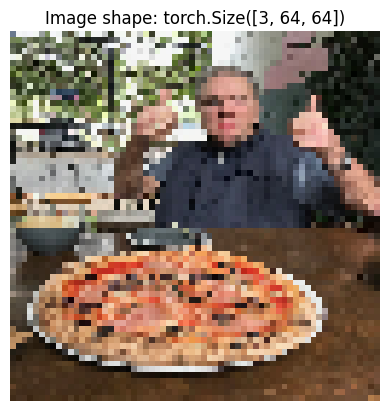

In [ ]:
# Plot custom image
plt.imshow(custom_image_resized.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC
plt.title(f"Image shape: {custom_image_resized.shape}")
plt.axis(False);

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_resized.unsqueeze(dim = 0).to(device))

custom_image_pred

tensor([[ 0.0747,  0.0447, -0.2100]])

> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - The model expects `torch.float32` where thge original custom image was `uint8`.
> 2. **Wrong shapes** - The model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas the custom image tensor was of shape `[color_channels, height, width]`.
> 2. **Wrong device** - If the model was on the target `device` (say, the GPU) whereas the target data hadn't been moved to the target `device` yet.

Keep in mind, these errors present with almost every kind of data type (text, audio, structured data) and problem being worked with.


#### **Functionalizing Custom Image Prediction**

Doing all of the above steps every time we'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    # 4. Make sure the model is on the target device
    model.to(device)
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

Let's test it out.

In [ ]:
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = transforms.Resize((64, 64)),
                    device = device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Looks like the model got the prediction right just by guessing.

> **Exercise:** Try making a prediction with one of your own images of pizza, steak or sushi and see what happens.

## Main takeaways

Let's summarise it with a few dot points.

* PyTorch has many in-built functions to deal with all kinds of data, from **vision to text to audio to recommendation systems**.
* If PyTorch's built-in data loading functions don't suit our requirements, we can write code to create our own custom datasets by subclassing `torch.utils.data.Dataset`.
* The `torch.utils.data.DataLoader` in PyTorch help turn our `Dataset` into batch iterables that can be used when training and testing a model.
* Predicting on a custom data with a trained model is possible, as long as the data type and shape are in a similar format to what the model was trained on. Make sure we take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Model expects `torch.float32` when the data is in other format say `torch.uint8`.
    2. **Wrong data shapes** - Model expects `[batch_size, color_channels, height, width]` when the data is `[color_channels, height, width]`.
    3. **Wrong devices** - Model is on GPU but data is on CPU.

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb)
* [Example solutions notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.
2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.
3. Recreate `model_0` we built in section 7.
4. Create training and testing functions for `model_0`.
5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
    * Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.
6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?
7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
    * **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
    * You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.
8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
    * Does the model you trained in exercise 7 get it right?
    * If not, what do you think you could do to improve it?

## Extra-curriculum

* To practice your knowledge of PyTorch `Dataset`'s and `DataLoader`'s through PyTorch [datasets and dataloaders tutorial notebook](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
* Spend 10-minutes reading the [PyTorch `torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).
    * You can see demos of transforms in action in the [illustrations of transforms tutorial](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms).
* Spend 10-minutes reading the PyTorch [`torchvision.datasets` documentation](https://pytorch.org/vision/stable/datasets.html).
    * What are some datasets that stand out to you?
    * How could you try building a model on these?
* [TorchData is currently in beta](https://pytorch.org/data/beta/index.html) (as of April 2022), it'll be a future way of loading data in PyTorch, but you can start to check it out now.
* To speed up deep learning models, you can do a few tricks to improve compute, memory and overhead computations, for more read the post [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He.